In [29]:
# from https://sisl.github.io/AutomotiveSimulator.jl/dev/tutorials/intersection/
using AutomotiveSimulator
using AutomotiveVisualization
using Random
using LinearAlgebra

In [30]:
include("lane_specific_driver.jl")
include("make_roundabout.jl")

make_roundabout (generic function with 1 method)

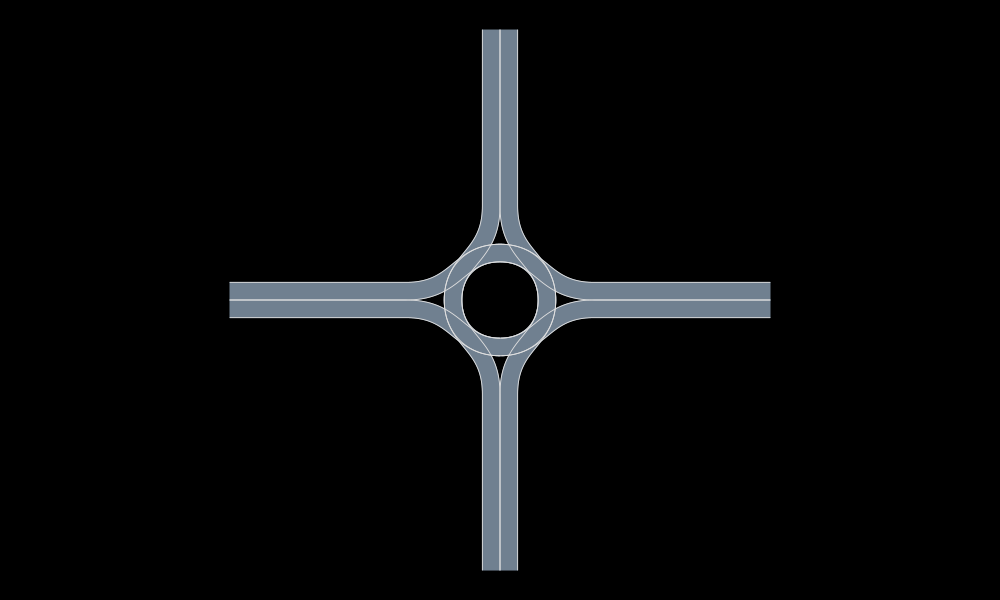

In [31]:
roadway = make_roundabout()
snapshot = render([roadway])

In [33]:
# Initialize a car at a given position on the road. Give it a lane number (1 = west, 2 = north, 3 = east, 4 = south) and a position offset
function init_car(lane::Symbol, id::Int, v_des=10.0, offset=0.0) :: Entity
    L = 30 # length of straight road
    r=8.0 # radius of circle
    # if 1 or 3, we are on the x-axis road
    if lane == :WEST
        veh = VehicleState(VecSE2(-L-r+offset, r-DEFAULT_LANE_WIDTH/2, 0.0), roadway, v_des)
    elseif lane == :NORTH # on y-axis driving towards -∞
        veh = VehicleState(VecSE2(-DEFAULT_LANE_WIDTH/2, L+2r-offset, 1.5π), roadway, v_des)
    elseif lane == :EAST
        veh = VehicleState(VecSE2(L+r-offset, r+DEFAULT_LANE_WIDTH/2, π), roadway, v_des)
    elseif lane == :SOUTH # on y-axis driving towards -∞
        veh = VehicleState(VecSE2(DEFAULT_LANE_WIDTH/2, -L+offset, 0.5π), roadway, v_des)
    else
        error("Unrecognized lane $lane")
    end
    return Entity(veh, VehicleDef(), id)
end

init_car (generic function with 3 methods)

In [34]:
timestep = 0.1
nticks = 200
L = 30 # length of straight road

# this doesn't work
#=
car_colors = Dict(:UNSAFE => RGB(0.95, 0.1, 0.1),
              :SAFE   => RGB(0.1, 0.95, 0.1),
              :RL     => RGB(0.6, 0.1, 0.6),)
=#
γ = 0.9
p = 0.5 # exploitation fraction

agent = initialize_agent(γ, p, nticks+1)
rl_driver = InterDriver(LaneSpecificAccelLatLon(0.0,0.0), 0, 10, 10, :ZERO, :RL, 1.0, agent)
rule_following_driver = InterDriver(LaneSpecificAccelLatLon(0.0,0.0), 0, 10, 10, :ZERO, :SAFE, 1.0)
# this driver breaks the rules half the time, maybe you know someone like this?
lawless_driver_05 = InterDriver(LaneSpecificAccelLatLon(0.0,0.0), 0, 10, 10, :ZERO, :UNSAFE, 0.5)

InterDriver(LaneSpecificAccelLatLon(0.0, 0.0), 0, 10, 10, :ZERO, :UNSAFE, 0.5, nothing)

In [35]:
# Init a scene with one RL agent, n_human_cars, and some fraction of rule followers
agent.ptr = 1
function init_scene(rl_driver::DriverModel, lawful_driver::DriverModel, lawless_driver::DriverModel, n_human_cars=4, frac_rule_following=1.0)
    n_lawful  = Integer(trunc(n_human_cars*frac_rule_following))
    n_lawless = n_human_cars - n_lawful
    
    dirs = [:WEST, :NORTH, :EAST, :SOUTH]
    offset = Dict(dirs[1] => 0.0, dirs[2] => 0.0, dirs[3] => 0.0, dirs[4] => 0.0)
  
    # generate a random list of directions for n+1 cars
    all_dirs = shuffle(repeat(dirs, Integer(ceil((n_human_cars+1)/4)) ))[1:n_human_cars+1]
    i = 1
    cars = Entity[]

    model = Dict{Int, DriverModel}()
    for d in all_dirs
        if i==1 # add the RL agent
            #println("adding RL agent at $d")
            push!(cars, init_car(d, i, 10.0+randn()*2., offset[d]))
            model[i] = rl_driver
            i += 1
            offset[d] += 8
        else
            #println("adding $d, id=$i")
            push!(cars, init_car(d, i, 10.0+randn()*2., offset[d]))
            model[i] = lawful_driver
            i += 1
            offset[d] += 8
        end
    end
    #println(offset)
    #println("added $(length(cars)) cars")
    scene = Scene(cars)
    return scene, model
end

scene, models = init_scene(rl_driver, rule_following_driver, lawless_driver_05, 5, 0.5)

scenes = simulate(scene, roadway, models, nticks, timestep)
#snapshot = render(renderables)

201-element Vector{Scene{Entity}}:
 Scene{Entity}(6 entities)
 Scene{Entity}(6 entities)
 Scene{Entity}(6 entities)
 Scene{Entity}(6 entities)
 Scene{Entity}(6 entities)
 Scene{Entity}(6 entities)
 Scene{Entity}(6 entities)
 Scene{Entity}(6 entities)
 Scene{Entity}(6 entities)
 Scene{Entity}(6 entities)
 Scene{Entity}(6 entities)
 Scene{Entity}(6 entities)
 Scene{Entity}(6 entities)
 ⋮
 Scene{Entity}(6 entities)
 Scene{Entity}(6 entities)
 Scene{Entity}(6 entities)
 Scene{Entity}(6 entities)
 Scene{Entity}(6 entities)
 Scene{Entity}(6 entities)
 Scene{Entity}(6 entities)
 Scene{Entity}(6 entities)
 Scene{Entity}(6 entities)
 Scene{Entity}(6 entities)
 Scene{Entity}(6 entities)
 Scene{Entity}(6 entities)

In [36]:
# Score the run, assuming the index 1 entity is the RL agent
function score(scenes)
    L=30 # length of straight road
    n = length(scenes[1]) # number of entities
    T=length(scenes) # number of steps
    # check collision
    s_start = posf(scenes[1][1]).s
    for t=1:T
        v_ego = scenes[t][1]
        if any(map( (v1) -> collision_checker(v_ego, v1), scenes[t].entities[2:end] ))
            #println("COLLISION detected with $v1")
            return (-1000.0, t-1) # collision!
        end
        if abs(s_start-posf(v_ego).s) >= 2.5L # done traversing
            #println("finished at $t, $(posf(v_ego).s)")
            return (10.0 + (T-t), t-1)
        end
    end
    return (0.1*abs(s_start-posf(scenes[end][1]).s),T-1)
end

score(scenes)

(4.133080169548151, 200)

In [37]:
#=
using Interact
using Reel
using Blink
#md
w = Window()
viz = @manipulate for step in 1 : length(scenes)
    render([roadway, scenes[step]])
end
body!(w, viz)
=#

## RL learning implementation

In [48]:
runs = 50
epochs = 20
frac_rule_following = 1.0
timestep = 0.1
nticks = 200
eps = 5e-4
γ = 0.9

# t tells us the last step to use for traj
# the reward occurs at the last step, we assume all other steps have 0 reward
function update!(agent::RLAgent, t::Int, reward::Float64, γ=0.9)
    #println(agent.s_record[t])
    agent.R[agent.s_record[t]] += reward
    old_counts = deepcopy(agent.counts)
    agent.counts[agent.s_record[1:t]] .+= 1
    agent.R .* old_counts ./= agent.counts
    for i=1:t-1
        agent.Tcounts[agent.a_record[i]][agent.s_record[i], agent.s_record[i+1]] += 1
    end
    agent.T = map(normalize, agent.Tcounts)
    agent.U = maximum(reduce(hcat, map((a) -> agent.R[:,a] + γ*agent.T[a]*agent.U, 1:n_actions)), dims=2)
    reset_record!(agent)
end


agent = rl_driver.agent
agent.ptr = 1
U_prev = copy(agent.U) .+ 1

for i=1:runs*epochs
    scene, models = init_scene(rl_driver, rule_following_driver, lawless_driver_05, 3, frac_rule_following)
    scenes = simulate(scene, roadway, models, nticks, timestep)
    reward, t = score(scenes)
    update!(agent, t, reward)
    #println("i = $i, r = $reward")
    
    # convergence check every epoch
    if div(i, runs) == 0
        ΔU = norm(agent.U - U_prev, 2)/norm(agent.U)
        println(ΔU)
        if ΔU < eps
            println("Converged in $i iterations")
            return
        end
        U_prev = copy(agent.U)
    end
    
end

0.004446417396529796
0.0006514661936144451
0.010910584804353127
0.0005761632916262575
0.0007709952602560805
0.007724504982553766
0.0006264209532577318
0.0007209002637850541
0.0005882134561784211
0.0007704883100883858
0.0008466709724918432
0.0006017457522952065
0.0005265344610114486
0.0006448872423908273
0.0006710614965709669
0.0009832973556517764
0.0009609256489300723
0.008835619807777306
0.0006369660192382341
0.0007220123371456097
0.0006800286999835675
0.0006496631317521113
0.00047203895139332933
Converged in 23 iterations


In [49]:
for ui in agent.U
    println(ui)
end

121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.793385

122.01286295560357
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.79190262965597
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
1676.4331657760802
4541.4310796174495
1029.9512864956214
2502.8440507873374
3375.7614805203
1121.5902134815306
1514.7048008353381
185.90442369458594
2281.7357817987904
1021.2890744571556
794.0840258126167
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
1

121.51450349639236
121.45233983204463
121.5055008472069
121.6056859441851
121.66529221761931
121.7023191659566
121.72614981308679
121.6721507228442
121.74953162050325
121.7865458891036
121.78659464390772
121.77310252864298
121.75935710153165
121.74230233062941
121.72225466241379
121.76279678679488
121.7933852168829
121.68897777497995
121.70585448781017
121.77988951363304
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.69234215212252
121.73273280255634
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.69213778523371
121.77314664934187
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
123.03114815411651
121.78695008586335
121.7933852168829
121.7933852168829
121.7933

121.75632282341338
121.77313490932964
121.78326253317623
121.7900124722134
121.77985621964288
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.77986114777168
121.7832242856523
121.76641092876012
121.7561754770246
121.75968036357382
121.7596036954801
121.70576457312372
121.7933852168829
121.7933852168829
121.78663073938195
121.73264286154803
121.66196576295228
121.61533723325326
121.61149204453226
121.6314796961451
121.65858813360619
121.67201450507591
121.66872605268304
121.7933852168829
121.78325599545306
121.72649520006259
121.62887714250866
121.55430770778712
121.51137928551152
121.56400926933443
121.64559331344711
121.71885916353423
121.75283047889417
121.75964932027982
121.7933852168829
121.74955322829858
121.67211081085429
121.65867248790393
121.6620305627847

121.78326005098475
121.78663823234807
121.7933852168829
121.7933852168829
121.73945960829822
121.66884361626457
121.66870899840545
121.69916383331113
121.76292059759517
121.78663571719942
121.78662490394863
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.72814846772232
121.642492198783
121.65185032682393
121.71545375360074
121.75294626601311
121.76979497106326
121.79000830277107
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
132.33710221325902
121.26654303945261
121.47526462881068
121.69912035036441
121.75962294378651
121.78325834750956
121.78662490394863
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
125.34866066250014
122.19348344347677
121.74951324244275
121.76297980276003
121.7731206137628
121.78999573063037
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
1208.4291648115181
128.68991897441524
121.63600727628348
121.63186987103111
121.66862619417542
121.71906030192

121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.78326257282902
121.73945204676197
121.75632036208826
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.73242259183176
121.58092228281804
121.52036763239488
121.59667778365986
121.65810722438844
121.74226249713114
121.77986530440025
121.78999409410429
121.7933852168829
121.7933852168829
121.7933852168829
121.75618908478121
121.63468071129341
121.54445701109391
121.49407670746255
121.57511073271199
121.66854619651036
121.74282704210275
121.77640834643184
121.7900099415779
121.7933852168829
121.78663992408424
121.78326257282902
121.76287299890394
121.68545706287489
121.5171331656193
121.4124296779467
121.46528865398834
121.57105637778265
121.70224983486776
121.76628488918367
121.78322229746323
121.7798978814438
121.75317856769045
121.77987862355674
121.76287309254485
121.70898369229424
121.58355966070394
121.454356806

1280.007093800778
1236.7829422695213
477.92992905415997
475.17900129949936
543.7000748636019
2374.5972075786635
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.7933852168829
121.79